In [9]:
import numpy as np
from numpy.random import *
import pymc3 as pm
from scipy.stats import uniform
import matplotlib.pyplot as plt

[0.14305886 0.66037315 0.73800245 ... 0.06088244 0.88217346 0.57198688] <class 'numpy.ndarray'>


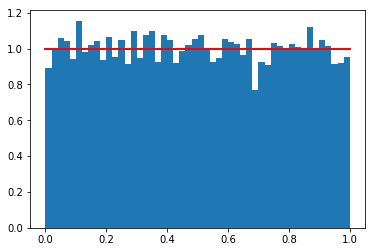

In [6]:
np.random.seed()
N = 10000
rv = uniform(loc=0, scale=1)
x = rv.rvs(size=N)
print(x, type(x))
nbins = 50
plt.hist(x, nbins, normed=True)

x = np.linspace(rv.ppf(0), rv.ppf(1), 100)
plt.plot(x, uniform.pdf(x), 'r-', lw=2, label='pdf')
plt.show()

In [47]:
def generate(p, size):
    return binomial(1, p=p, size=size) #1d
    
print(generate(0.4, 20))

[0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 0]


In [51]:
control = generate(0.15, 1000)
treat = generate(0.17, 9000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [theta_c_interval__]
>Metropolis: [theta_t_interval__]
100%|██████████| 10500/10500 [00:03<00:00, 3015.81it/s]
The number of effective samples is smaller than 25% for some parameters.


             mean        sd  mc_error   hpd_2.5  hpd_97.5   n_eff      Rhat
theta_t  0.167998  0.003852  0.000052  0.160634  0.175358  4085.0  1.000075
theta_c  0.157249  0.011378  0.000167  0.135604  0.179708  3969.0  1.000618
delta    0.010749  0.012005  0.000176 -0.012842  0.033445  4094.0  1.000387


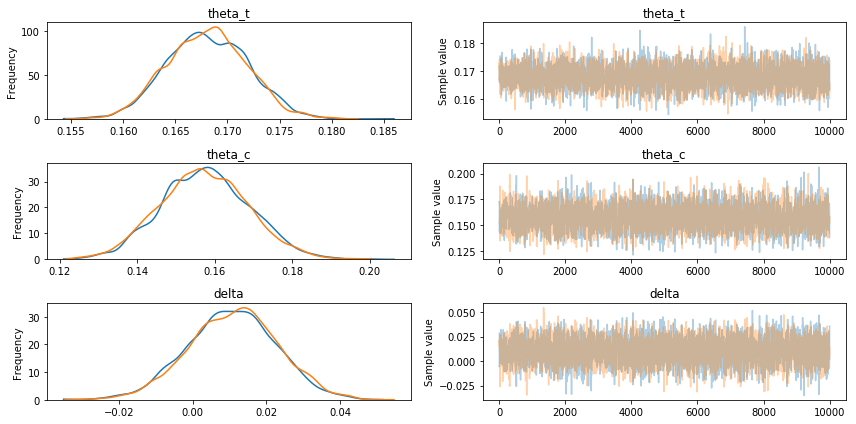

10000

In [79]:
with pm.Model() as model:
    theta_t = pm.Uniform("theta_t", 0, 1)
    theta_c = pm.Uniform("theta_c", 0, 1)
    
    delta = pm.Deterministic("delta", theta_t - theta_c)
    
    obs_t = pm.Bernoulli("obs_t", theta_t, observed=treat)
    obs_c = pm.Bernoulli("obs_c", theta_c, observed=control)
    
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step, njobs=2, chains=2)
    burn = trace[1000:]
print(pm.summary(trace))
pm.traceplot(trace)
plt.show()
len(trace)

['theta_t_interval__', 'theta_c_interval__', 'theta_t', 'theta_c', 'delta']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1201755f8>,
      dtype=object)

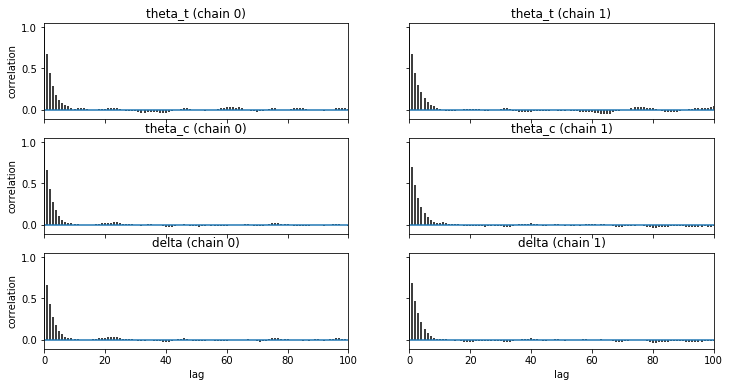

In [91]:
print(trace.varnames)
pm.plots.autocorrplot(trace)

In [80]:
theta_t_samples = burn["theta_t"]
theta_c_samples = burn["theta_c"]
delta_samples = burn["delta"]
print(delta_samples[0:50])

[-0.01006152  0.0243721   0.0243721   0.0243721   0.0243721   0.0243721
  0.0243721   0.01221919  0.01120941  0.01120941  0.01120941  0.01736786
  0.01736786  0.01668247  0.01295408  0.01295408  0.00788753  0.00788753
  0.00788753  0.00518662  0.00608677  0.00608677  0.01052244  0.00266638
  0.00510692  0.00510692  0.00510692  0.00510692  0.00510692  0.00510692
  0.00510692  0.00510692  0.02352577  0.02352577  0.03023546  0.03023546
  0.03023546  0.02694384  0.02694384  0.02694384  0.02694384 -0.00652766
  0.01073637  0.01546756  0.01546756  0.01546756  0.01546756  0.01546756
  0.01546756  0.01546756]


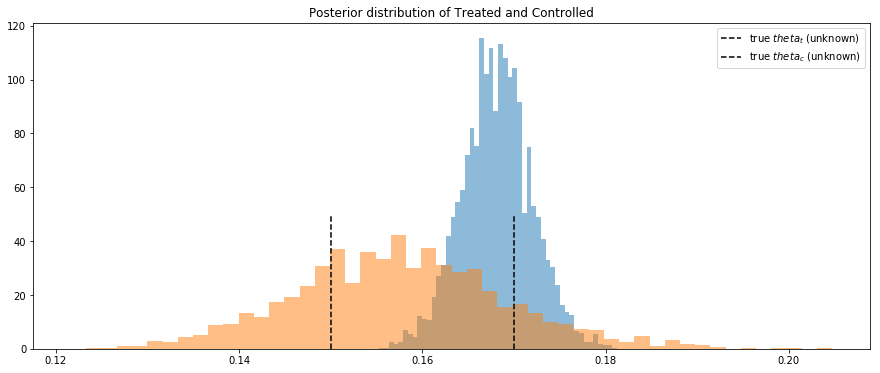

In [76]:
plt.figure(figsize=(15, 6))
plt.title("Posterior distribution of Treated and Controlled")
plt.vlines(0.17, 0, 50, linestyle="--", label="true $theta_t$ (unknown)")
plt.vlines(0.15, 0, 50, linestyle="--", label="true $theta_c$ (unknown)")
plt.hist(theta_t_samples, bins=50, histtype="stepfilled", normed=True, alpha=0.5)
plt.hist(theta_c_samples, bins=50, histtype="stepfilled", normed=True, alpha=0.5)
plt.legend()
plt.show()


[-0.01987383  0.04181832]


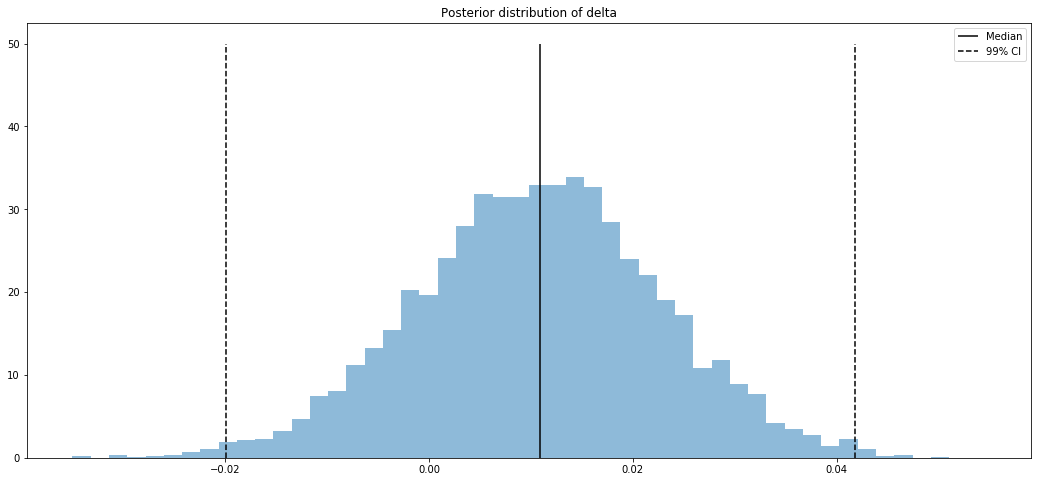

In [81]:
CI = pm.stats.hpd(delta_samples, alpha=0.01)
print(CI)
plt.figure(figsize=(18, 8))
plt.title("Posterior distribution of delta")
plt.vlines(np.median(delta_samples), 0, 50, linestyle="-", label="Median")
plt.vlines(CI[0], 0, 50, linestyle="--", label="99% CI")
plt.vlines(CI[1], 0, 50, linestyle="--")
plt.hist(delta_samples, bins=50, histtype="stepfilled", normed=True, alpha=0.5)
plt.legend()
plt.show()

In [78]:
print((delta_samples>0).sum()/len(delta_samples))

0.8173333333333334


(41,) (41,)


<Container object of 41 artists>

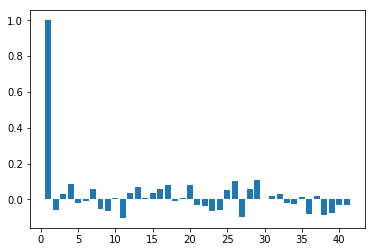

In [94]:
import statsmodels.api as sm
theta_c_samples = theta_c_samples[::3]
cor = sm.tsa.stattools.acf(theta_c_samples)
x = np.arange(1, len(cor) + 1)
print(cor.shape, x.shape)
plt.bar(x, cor)